# Sentiment Analysis with Deep Learning using BERT

## Exploratory Data Analysis

We will use the SMILE Twitter dataset.

_Wang, Bo; Tsakalidis, Adam; Liakata, Maria; Zubiaga, Arkaitz; Procter, Rob; Jensen, Eric (2016): SMILE Twitter Emotion dataset. figshare. Dataset. https://doi.org/10.6084/m9.figshare.3187909.v2_

In [1]:
#libraries and packages
!pip install torch
import torch
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
#load data
df = pd.read_csv('smile-annotations-final.csv',
                 names = ['id', 'text', 'category'])

#reset index
df.set_index('id', inplace = True)

In [3]:
#preview
df.head()

,text,category
id,,
611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
614877582664835073,@Sofabsports thank you for following me back. ...,happy
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy


In [4]:
#info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3085 entries, 611857364396965889 to 611566876762640384
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      3085 non-null   object
 1   category  3085 non-null   object
dtypes: object(2)
memory usage: 72.3+ KB


In [5]:
#check for null
df.isnull().sum()

,0
text,0
category,0


In [6]:
#look at an example
df.text.iloc[10]

'"1...2..." "non arrête mon brush!". l.Alma|A favourite custom|1909 @NationalGallery #bonlundi http://t.co/HpjvSJHGhP'

In [7]:
#count for each class
df.category.value_counts()

,count
category,
nocode,1572
happy,1137
not-relevant,214
angry,57
surprise,35
sad,32
happy|surprise,11
happy|sad,9
disgust|angry,7


In [8]:
#drop irrelevent class
df = df[~df.category.str.contains('\|')]

<>:2: SyntaxWarning: invalid escape sequence '\|'
<>:2: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipython-input-1503810953.py:2: SyntaxWarning: invalid escape sequence '\|'
  df = df[~df.category.str.contains('\|')]


In [9]:
#drop irrelevent class
df = df[df.category != 'nocode']

In [10]:
#final classes
df.category.value_counts()

,count
category,
happy,1137
not-relevant,214
angry,57
surprise,35
sad,32
disgust,6


/tmp/ipython-input-3372830992.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df.category, palette='Spectral')


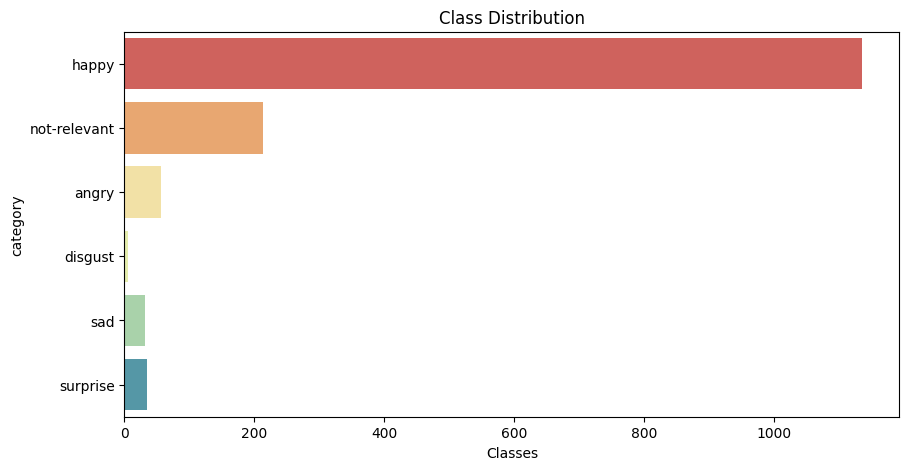

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

#plot class distribution
plt.figure(figsize=(10, 5))
sns.countplot(df.category, palette='Spectral')
plt.xlabel('Classes')
plt.title('Class Distribution');

In [12]:
#store classes into an array
possible_labels = df.category.unique()
possible_labels

array(['happy', 'not-relevant', 'angry', 'disgust', 'sad', 'surprise'],
      dtype=object)

In [13]:
#convert labels into numeric values
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [14]:
label_dict

{'happy': 0,
 'not-relevant': 1,
 'angry': 2,
 'disgust': 3,
 'sad': 4,
 'surprise': 5}

In [15]:
#convert labels into numeric values
df['label'] = df.category.replace(label_dict)
df.head(10)

/tmp/ipython-input-3174815933.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df.category.replace(label_dict)


,text,category,label
id,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0
614877582664835073,@Sofabsports thank you for following me back. ...,happy,0
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0
614499696015503361,Lucky @FitzMuseum_UK! Good luck @MirandaStearn...,happy,0
613601881441570816,Yr 9 art students are off to the @britishmuseu...,happy,0
613696526297210880,@RAMMuseum Please vote for us as @sainsbury #s...,not-relevant,1
610746718641102848,#AskTheGallery Have you got plans to privatise...,not-relevant,1


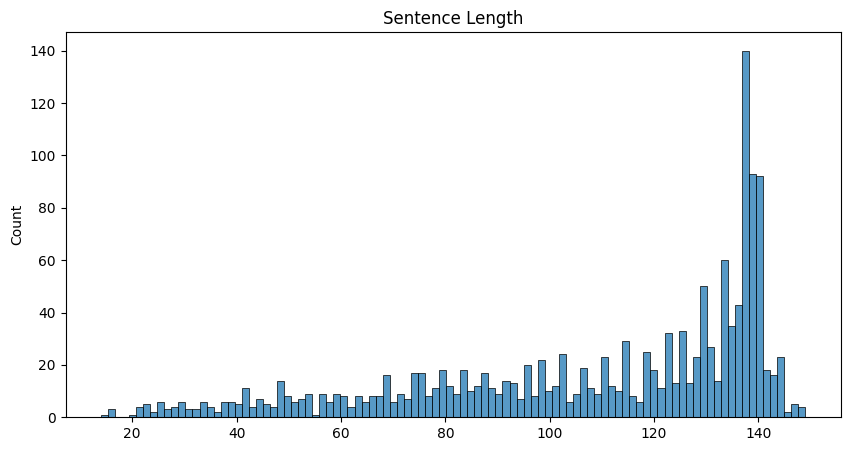

In [16]:
#need equal length sentences
#plot hist of sentence length
plt.figure(figsize=(10, 5))
sns.histplot([len(s) for s in df.text], bins=100)
plt.title('Sentence Length')
plt.show()

In [17]:
#find the maximum length
max_len = max([len(sent) for sent in df.text])
print('Max length: ', max_len)

Max length:  149


## Train Test Split

In [18]:
from sklearn.model_selection import train_test_split

#train test split
X_train, X_val, y_train, y_val = train_test_split(df.index.values,
                                                   df.label.values,
                                                   test_size = 0.15,
                                                   random_state = 17,
                                                   stratify = df.label.values)

In [19]:
#create new column
df['data_type'] = ['not_set'] * df.shape[0]
df.head()

,text,category,label,data_type
id,,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0,not_set
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0,not_set
614877582664835073,@Sofabsports thank you for following me back. ...,happy,0,not_set
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0,not_set
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0,not_set


In [20]:
#fill in data type
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [21]:
df.groupby(['category', 'label', 'data_type']).count()

text
category     label data_type      
angry        2     train        48
                   val           9
disgust      3     train         5
                   val           1
happy        0     train       966
                   val         171
not-relevant 1     train       182
                   val          32
sad          4     train        27
                   val           5
surprise     5     train        30
                   val           5

## Tokenization

In [22]:
!pip install transformers

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [23]:
#load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                         do_lower_case = True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


In [24]:
#tokenize train set
encoded_data_train = tokenizer.batch_encode_plus(df[df.data_type == 'train'].text.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                padding = 'max_length', # Changed from pad_to_max_length
                                                truncation = True, # Added truncation
                                                max_length = 150,
                                                return_tensors = 'pt')

In [25]:
#tokenizer val set
encoded_data_val = tokenizer.batch_encode_plus(df[df.data_type == 'val'].text.values,
                                                add_special_tokens = True, # Added missing argument
                                                return_attention_mask = True,
                                                padding = 'max_length', # Changed from pad_to_max_length
                                                truncation = True, # Added truncation
                                                max_length = 150,
                                                return_tensors = 'pt')

In [26]:
encoded_data_train

{'input_ids': tensor([[  101, 16092,  3897,  ...,     0,     0,     0],
        [  101,  1030, 27034,  ...,     0,     0,     0],
        [  101,  1030, 10682,  ...,     0,     0,     0],
        ...,
        [  101, 11047,  1030,  ...,     0,     0,     0],
        [  101,  1030,  3680,  ...,     0,     0,     0],
        [  101,  1030,  2120,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

## Encoding

In [27]:
#encode train set
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type == 'train'].label.values)

In [28]:
#encode val set
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']

#convert data type to torch.tensor
labels_val = torch.tensor(df[df.data_type == 'val'].label.values)

In [29]:
input_ids_train

tensor([[  101, 16092,  3897,  ...,     0,     0,     0],
        [  101,  1030, 27034,  ...,     0,     0,     0],
        [  101,  1030, 10682,  ...,     0,     0,     0],
        ...,
        [  101, 11047,  1030,  ...,     0,     0,     0],
        [  101,  1030,  3680,  ...,     0,     0,     0],
        [  101,  1030,  2120,  ...,     0,     0,     0]])

In [30]:
attention_masks_train

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [31]:
labels_train

tensor([0, 0, 0,  ..., 0, 0, 1])

In [32]:
#create dataloader
dataset_train = TensorDataset(input_ids_train,
                              attention_masks_train,
                              labels_train)

dataset_val = TensorDataset(input_ids_val,
                             attention_masks_val,
                             labels_val)

In [33]:
print(len(dataset_train))
print(len(dataset_val))

1258
223


In [34]:
dataset_train

In [35]:
dataset_train.tensors

(tensor([[  101, 16092,  3897,  ...,     0,     0,     0],
         [  101,  1030, 27034,  ...,     0,     0,     0],
         [  101,  1030, 10682,  ...,     0,     0,     0],
         ...,
         [  101, 11047,  1030,  ...,     0,     0,     0],
         [  101,  1030,  3680,  ...,     0,     0,     0],
         [  101,  1030,  2120,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([0, 0, 0,  ..., 0, 0, 1]))

## Set Up BERT Pretrained Model

In [36]:
from transformers import BertForSequenceClassification

#load pre-trained BERT
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = len(label_dict),
                                                      output_attentions = False,
                                                      output_hidden_states = False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
#model summary
model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dtype": "float32",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

## Create Data Loaders

In [38]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 4 #since we have limited resource

#load train set
dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = batch_size)

#load val set
dataloader_val = DataLoader(dataset_val,
                              sampler = RandomSampler(dataset_val),
                              batch_size = 32) #since we don't have to do backpropagation for this step

## Define Performance Metrics

In [42]:
#preds = [0.9 0.05 0.05 0 0 0]
#preds = [1 0 0 0 0 0]

In [43]:
import numpy as np
from sklearn.metrics import f1_score

#f1 score
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [44]:
#accuracy score
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    #make prediction
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [45]:
def evaluate(dataloader_val):

    #evaluation mode disables the dropout layer
    model.eval()

    #tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in tqdm(dataloader_val):

        #load into GPU
        batch = tuple(b.to(device) for b in batch)

        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():
            outputs = model(**inputs)

        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

## Train Model

In [46]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


## Model Evaluation


In [50]:
outputs.loss

tensor(1.6919, device='cuda:0', grad_fn=<NllLossBackward0>)

In [51]:
outputs.logits

tensor([[ 0.2871, -0.2916, -0.4921, -0.7029, -0.0118, -0.0345],
        [ 0.0574, -0.0734, -0.3841, -0.8368,  0.0641,  0.2573],
        [ 0.4549, -0.0402, -0.3387, -0.5911,  0.1697,  0.2454],
        [ 0.3039, -0.2841, -0.8261, -0.6708, -0.2799, -0.1932]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [52]:
#save model
model.to(device)
pass

In [53]:
#evaluate
_, predictions, true_vals = evaluate(dataloader_val)

  0%|          | 0/7 [00:00<?, ?it/s]

In [54]:
#get accuracy score
accuracy_per_class(predictions, true_vals)

Class: happy
Accuracy:103/171

Class: not-relevant
Accuracy:0/32

Class: angry
Accuracy:0/9

Class: disgust
Accuracy:0/1

Class: sad
Accuracy:0/5

Class: surprise
Accuracy:4/5

